# Apply and Visualize UMAP

**Gregory Way, 2019**

Apply UMAP to merged batch 1 and batch 3 data

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(umap))

In [2]:
set.seed(12345)

In [3]:
# Load labels
file = file.path("data", "category_labels.csv")
label_df = readr::read_csv(file, col_types=readr::cols())
colnames(label_df) <- paste0("Metadata_", colnames(label_df))

label_df

Metadata_T2D_bin,Metadata_quantile_T2D,Metadata_percentile_T2D,Metadata_rank_T2D,Metadata_percentile_HOMA-IR,Metadata_rank_HOMA-IR,Metadata_IID,Metadata_category
<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>
0,NA,87.50,161.0,47.83,88,m164,1
1,NA,81.52,150.0,80.43,148,m246,1
1,NA,23.91,44.0,39.67,73,m252,0
0,0,38.32,70.5,93.48,172,m266,1
1,0,57.61,106.0,8.70,16,m270,0
1,NA,92.39,170.0,79.35,146,m272,1
0,NA,93.48,172.0,16.85,31,m276,0


In [4]:
file <- file.path("data", "batch1_batch3_combined_normalized_variable_selected.tsv")

cp_cols <- readr::cols(
    .default = readr::col_double(),
    Metadata_Batch = readr::col_character(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_Assay_Plate_Barcode = readr::col_character(),
    Metadata_Plate_Map_Name = readr::col_character(),
    Metadata_well_position = readr::col_character(),
    Metadata_cell_line = readr::col_character(),
    Metadata_patient = readr::col_character(),
    Metadata_FFA = readr::col_character(),
    Metadata_diff_day = readr::col_character()
)

df <- readr::read_tsv(file, col_types = cp_cols) %>%
    dplyr::filter(Metadata_FFA == 0)

recode_patient <- paste0("m", gsub("PAC_", "", df$Metadata_patient))
df$Metadata_patient <- recode_patient
df$Metadata_patient_merge <- recode_patient

df <- label_df %>%
    dplyr::inner_join(df, by = c("Metadata_IID" = "Metadata_patient_merge"), keep_all = TRUE)

dim(df)
head(df, 2)

Warning message:
“`chr_along()` is deprecated as of rlang 0.2.0.
This warning is displayed once per session.”

[1] 290 697

Metadata_T2D_bin,Metadata_quantile_T2D,Metadata_percentile_T2D,Metadata_rank_T2D,Metadata_percentile_HOMA-IR,Metadata_rank_HOMA-IR,Metadata_IID,Metadata_category,Metadata_Plate,Metadata_Well,⋯,Cells_Texture_Correlation_ER_20_00,Cytoplasm_RadialDistribution_RadialCV_AGP_2of4,Cytoplasm_Correlation_Costes_AGP_Mito,Cytoplasm_Texture_AngularSecondMoment_ER_20_01,Cytoplasm_Texture_InfoMeas2_AGP_10_01,Nuclei_Correlation_K_Mito_AGP,Cells_RadialDistribution_MeanFrac_AGP_1of4,Nuclei_RadialDistribution_MeanFrac_AGP_4of4,Cells_RadialDistribution_MeanFrac_ER_3of4,Cytoplasm_Texture_InfoMeas1_DNA_5_03
<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,NA,87.5,161,47.83,88,m164,1,BR00101080,B07,⋯,-0.8102294,-1.124198,0.005995777,-0.1973605,-0.3003318,-0.3158257,-1.2793731,1.03534362,-1.0638875,1.03197823
0,NA,87.5,161,47.83,88,m164,1,BR00101080,B08,⋯,0.5562114,-1.284908,-0.168533236,0.1546437,-0.6380676,-0.7065492,-0.1958039,0.07881592,0.3475791,0.06399096


In [5]:
metadata_df <- df %>%
    dplyr::select(dplyr::starts_with("Metadata_"))

cp_df <- df %>%
    dplyr::select(-dplyr::starts_with("Metadata_"))

In [6]:
# Apply UMAP
cp_umap <- umap(as.matrix(cp_df))
cp_umap_df <- cp_umap$layout %>%
    dplyr::as_tibble()

colnames(cp_umap_df) <- c("umap_x", "umap_y")

# Merge with metadata
cp_umap_df <- cp_umap_df %>%
    dplyr::bind_cols(metadata_df)

head(cp_umap_df, 2)

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”

umap_x,umap_y,Metadata_T2D_bin,Metadata_quantile_T2D,Metadata_percentile_T2D,Metadata_rank_T2D,Metadata_percentile_HOMA-IR,Metadata_rank_HOMA-IR,Metadata_IID,Metadata_category,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_cell_line,Metadata_patient,Metadata_FFA,Metadata_diff_day,Metadata_Batch
<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
3.1853249,-0.1947562,0,NA,87.5,161,47.83,88,m164,1,BR00101080,B07,BR00101080,BR00101080,B07,sc,m164,0,3,batch_one
0.4617039,3.0559609,0,NA,87.5,161,47.83,88,m164,1,BR00101080,B08,BR00101080,BR00101080,B08,vc,m164,0,3,batch_one


In [7]:
cp_umap_df <- cp_umap_df %>%
    dplyr::select(umap_x,
                  umap_y,
                  Metadata_Plate,
                  Metadata_Well,
                  Metadata_cell_line,
                  Metadata_patient,
                  Metadata_diff_day,
                  Metadata_Batch,
                  Metadata_T2D_bin,
                  Metadata_quantile_T2D,
                  Metadata_percentile_T2D,
                  Metadata_rank_T2D,
                  `Metadata_percentile_HOMA-IR`,
                  `Metadata_rank_HOMA-IR`,
                  `Metadata_IID`,
                  `Metadata_category`) %>%
    dplyr::rename(x = umap_x,
                  y = umap_y,
                  Plate = Metadata_Plate,
                  Well = Metadata_Well,
                  Cell_Line = Metadata_cell_line,
                  Patient = Metadata_patient,
                  Day = Metadata_diff_day,
                  Batch = Metadata_Batch,
                  `T2D Bin` = Metadata_T2D_bin,
                  `T2D Quantile` = Metadata_quantile_T2D,
                  `T2D Percentile` = Metadata_percentile_T2D,
                  `T2D Rank` = Metadata_rank_T2D,
                  `HOMA-IR Percentile` = `Metadata_percentile_HOMA-IR`,
                  `HOMA-IR Rank` = `Metadata_rank_HOMA-IR`,
                  `IID` = `Metadata_IID`,
                  `Category` = `Metadata_category`)

head(cp_umap_df, 2)

x,y,Plate,Well,Cell_Line,Patient,Day,Batch,T2D Bin,T2D Quantile,T2D Percentile,T2D Rank,HOMA-IR Percentile,HOMA-IR Rank,IID,Category
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>
3.1853249,-0.1947562,BR00101080,B07,sc,m164,3,batch_one,0,NA,87.5,161,47.83,88,m164,1
0.4617039,3.0559609,BR00101080,B08,vc,m164,3,batch_one,0,NA,87.5,161,47.83,88,m164,1


In [8]:
cp_umap_df$Day <- dplyr::recode(cp_umap_df$Day, "15+iso" = "15")
cp_umap_df$Day <- factor(cp_umap_df$Day, levels = sort(as.numeric(paste(unique(cp_umap_df$Day)))))

In [9]:
# Write umap output
file <- file.path("umap_shiny", "data", "combined_batch1_batch3_umap_with_metadata.tsv")
readr::write_tsv(cp_umap_df, file)

## Visualize UMAP Compression

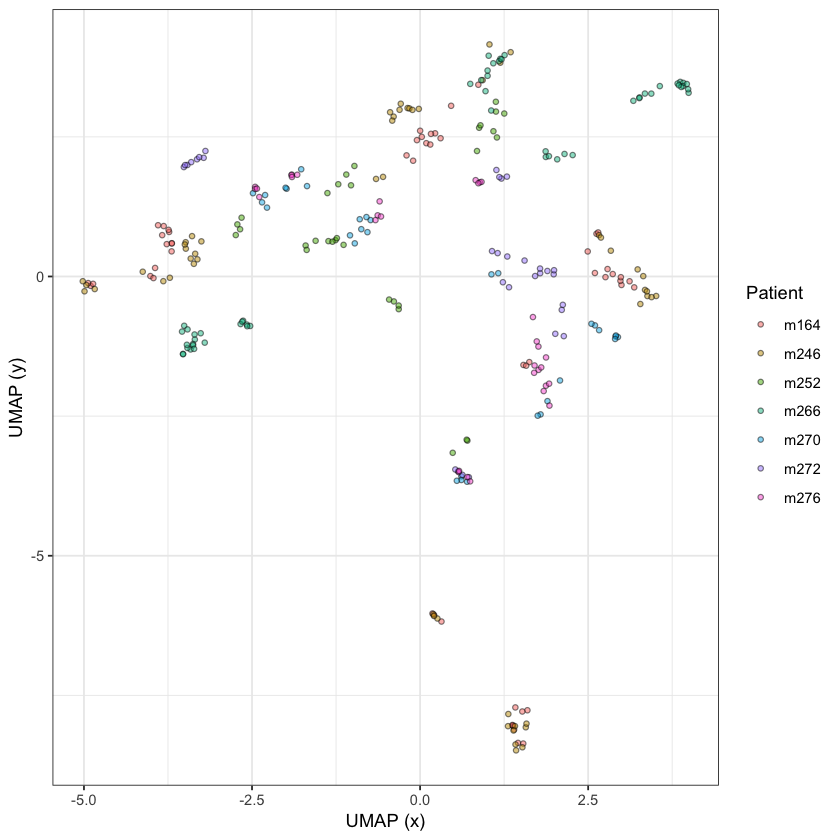

In [10]:
patient_gg <- ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(fill = Patient),
               size = 1.2,
               alpha = 0.5,
               color = "black",
               pch = 21) +
    theme_bw() +
    scale_fill_discrete(name = "Patient") +
    xlab("UMAP (x)") +
    ylab("UMAP (y)")

patient_gg

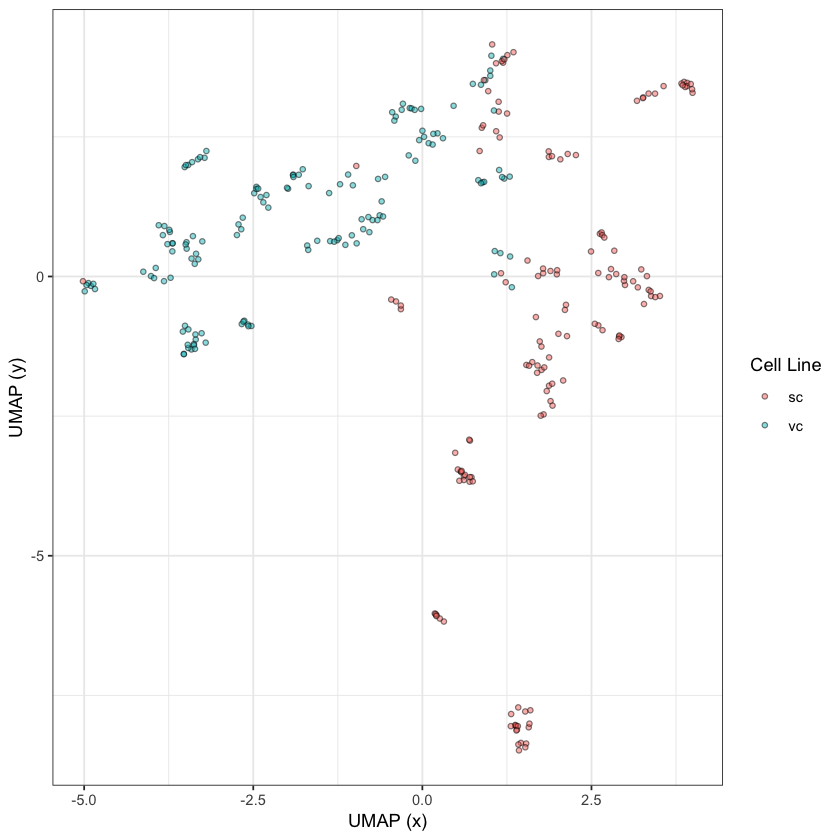

In [11]:
cell_line_gg <- ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(fill = Cell_Line),
               size = 1.2,
               alpha = 0.5,
               color = "black",
               pch = 21) +
    theme_bw() +
    scale_fill_discrete(name = "Cell Line") +
    xlab("UMAP (x)") +
    ylab("UMAP (y)")

cell_line_gg

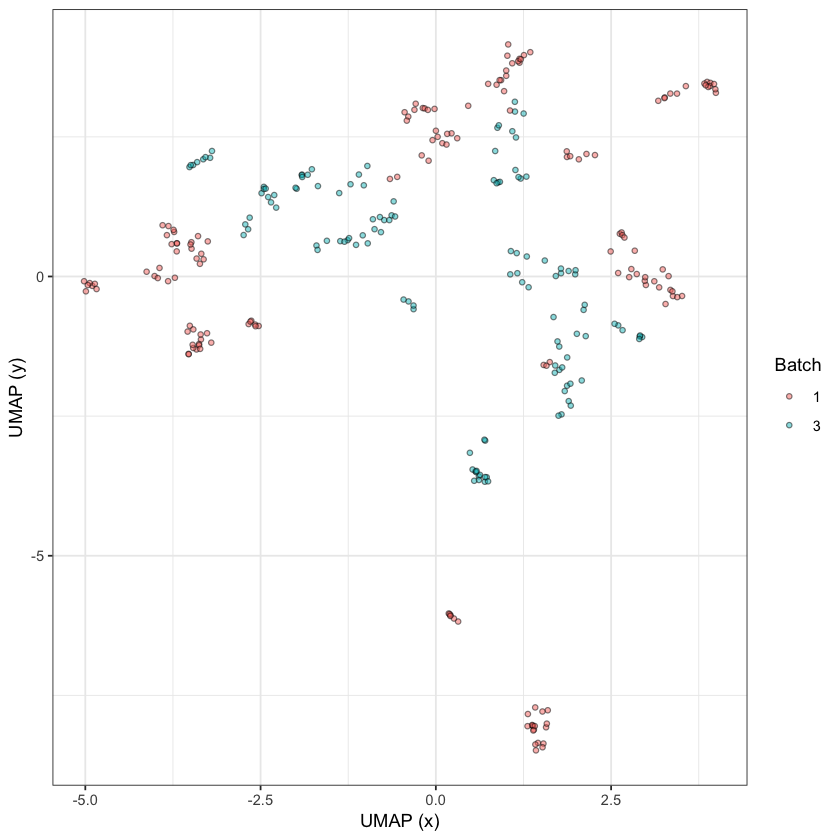

In [12]:
batch_gg <- ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(fill = Batch),
               size = 1.2,
               alpha = 0.5,
               color = "black",
               pch = 21) +
    theme_bw() +
    scale_fill_discrete(name = "Batch",
                        labels = c("batch_one" = "1",
                                   "batch_three" = "3")) +
    xlab("UMAP (x)") +
    ylab("UMAP (y)")
 
batch_gg

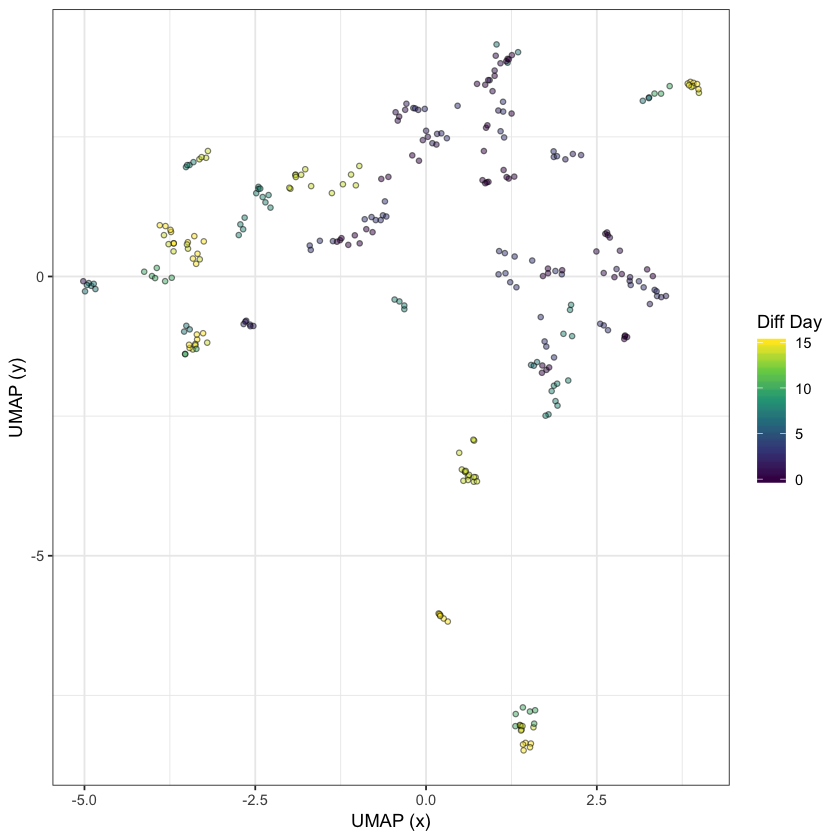

In [13]:
day_gg <- ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(fill = as.numeric(paste(Day))),
               size = 1.2,
               alpha = 0.5,
               color = "black",
               pch = 21) +
    theme_bw() +
    scale_fill_viridis_c(name = "Diff Day") +
    xlab("UMAP (x)") +
    ylab("UMAP (y)")
 
day_gg

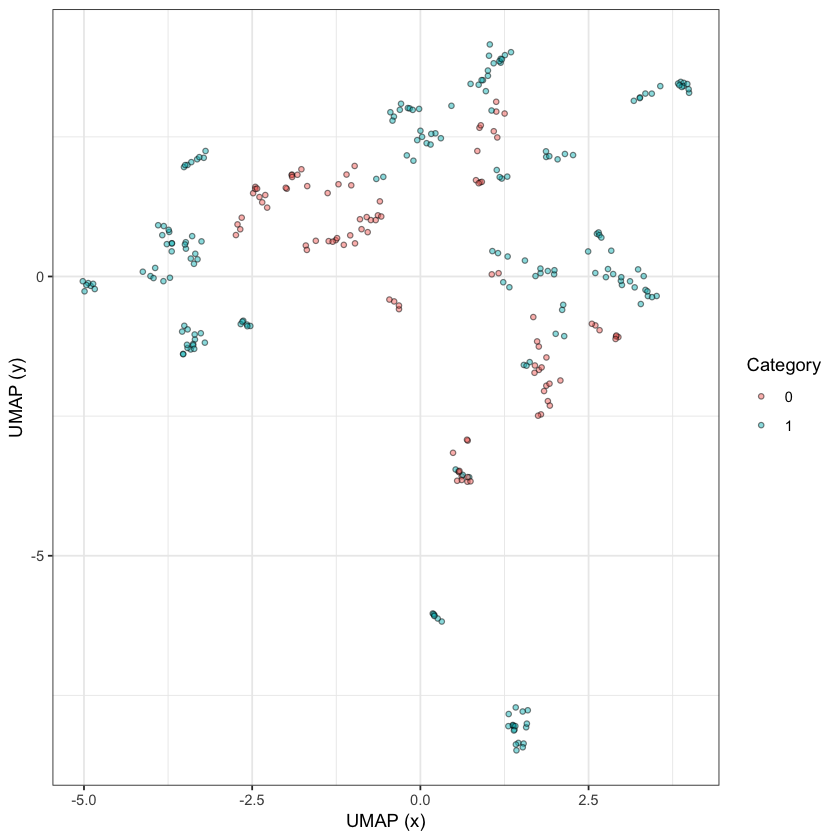

In [14]:
category_gg <- ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(fill = factor(Category)),
               size = 1.2,
               alpha = 0.5,
               color = "black",
               pch = 21) +
    theme_bw() +
    scale_fill_discrete(name = "Category") +
    xlab("UMAP (x)") +
    ylab("UMAP (y)")
 
category_gg

## Combine Plots into Single Cowplot

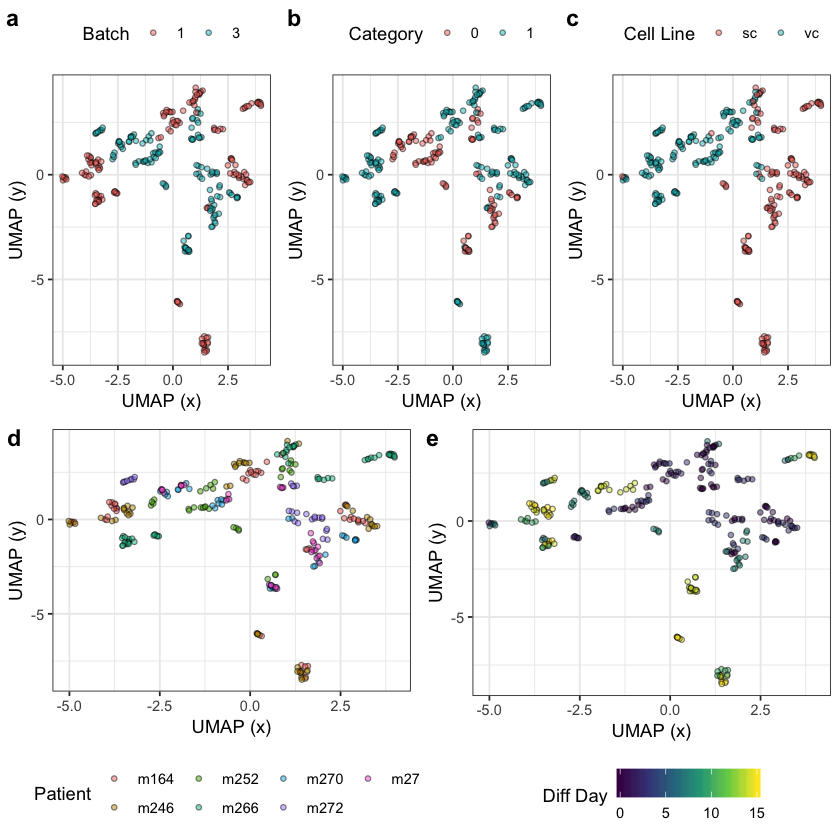

In [15]:
top_row <- (
    cowplot::plot_grid(
        batch_gg + theme(legend.position = "top"),
        category_gg + theme(legend.position = "top"),
        cell_line_gg + theme(legend.position = "top"),
        labels = c("a", "b", "c"),
        ncol = 3
    )
)

bottom_row <- (
    cowplot::plot_grid(
        patient_gg + theme(legend.position = "bottom"),
        day_gg + theme(legend.position = "bottom"),
        labels = c("d", "e"),
        ncol = 2
    )
)


main_plot <- (
    cowplot::plot_grid(
        top_row,
        bottom_row,
        ncol = 1,
        nrow = 2,
        align = "v"
    )
)

main_plot

In [16]:
for(extension in c('.png', '.pdf')) {
    sup_file <- paste0("umap_metadata_batch1_batch3_combined", extension)
    sup_file <- file.path("figures", sup_file)
    cowplot::save_plot(filename = sup_file,
                       plot = main_plot,
                       base_height = 130,
                       base_width = 240,
                       unit = "mm")
}

## Time Points in Visceral and Subcutaneous Tissue

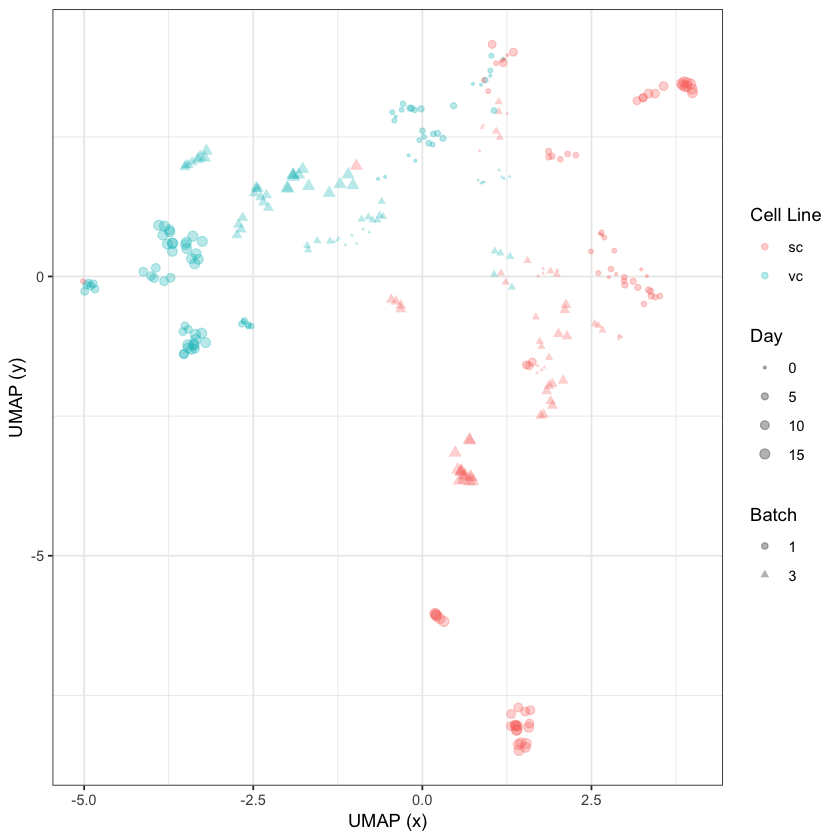

In [17]:
ggplot(cp_umap_df, aes(x, y)) +
    geom_point(aes(color = Cell_Line,
                   size = as.numeric(paste(Day)),
                   shape = Batch),
               alpha = 0.3) +
    theme_bw() +
    scale_size_continuous(name = "Day",
                          range = c(0.5, 2.5)) +
    scale_color_discrete(name = "Cell Line") +
    scale_shape_manual(name = "Batch",
                       values = c(19, 17),
                       labels = c("batch_one" = "1",
                                  "batch_three" = "3")) +
    xlab("UMAP (x)") +
    ylab("UMAP (y)") +
    theme(strip.text.x = element_text(size = 10),
          strip.text.y = element_text(size = 7),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

output_file <- file.path("figures", "umap_batch1_batch3_day_line_batch.png")
ggsave(output_file, height = 5, width = 6, dpi = 300)